In [3]:
import pandas as pd

df = pd.read_table('../data/SMSSpamCollection', header=None)
df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

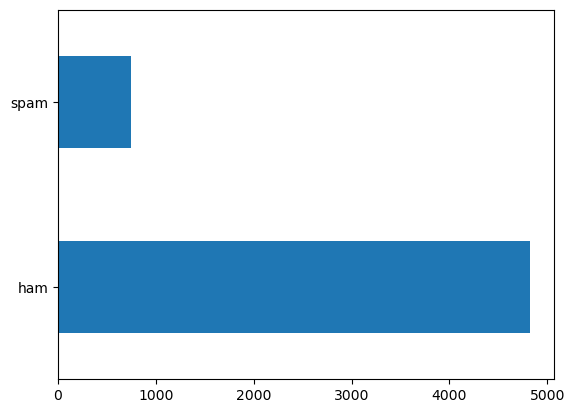

In [4]:
df['label'].value_counts().plot(kind='barh')

## Text Preprocessing

1. Remove Punctuations
2. Remove Stopwords
3. Remove Affixes (Stemming)

In [5]:
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string


In [7]:
punctuations = string.punctuation
stopword = stopwords.words('english')
ls = LancasterStemmer()
wnl = WordNetLemmatizer()

def clean_text(text):
    tokens1 = word_tokenize(text)
    tokens2 = [x.lower() for x in tokens1 if x not in punctuations]
    tokens3 = [ls.stem(x) for x in tokens2 if x not in stopword]

    tokens4 = []
    tags = pos_tag(tokens3)
    for word in tags:
        if word[1].startswith('N'):
            tokens4.append(wnl.lemmatize(word[0], pos='n'))
        if word[1].startswith('V'):
            tokens4.append(wnl.lemmatize(word[0], pos='v'))
        if word[1].startswith('R'):
            tokens4.append(wnl.lemmatize(word[0], pos='r'))    
        if word[1].startswith('J'):
            tokens4.append(wnl.lemmatize(word[0], pos='a'))

    return tokens4

sent = "When we visit the ground no one was playing."
clean_text(sent)

['visit', 'gorund', 'play']

In [8]:
df['text'].apply(lambda x: clean_text(x))

0       [go, jurong, point, crazy, .., avail, bug, gre...
1                                  [ok, lar, jok, wif, u]
2       [fre, entry, wkly, comp, win, fa, cup, fin, tk...
3             [u, dun, say, ear, hor, u, c, already, say]
4                        [nah, n't, think, goe, usf, liv]
                              ...                        
5567    [tim, tri, contact, u., u, £750, pound, priz, ...
5568                        [ü, b, go, esplanad, fr, hom]
5569                                [pity, mood, suggest]
5570    [guy, bitch, act, lik, interest, buy, someth, ...
5571                                     [rofl, tru, nam]
Name: text, Length: 5572, dtype: object

### TF*IDF Vectorizer

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer=clean_text)

x_vect = tfidf.fit_transform(df['text'])
x_vect.shape

(5572, 6244)

In [10]:
tfidf.get_feature_names_out()

array(["'anything", "'comfort", "'d", ..., '…thanks', '〨ud', '鈥┾'],
      dtype=object)

### Cross Validation

In [11]:
y = df['label']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_vect, y, test_size=0.25, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4179, 6244), (1393, 6244), (4179,), (1393,))

### Build the Model

In [13]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [14]:
y_pred = classifier.predict(X_test)
y_pred

array(['ham', 'ham', 'ham', ..., 'spam', 'ham', 'ham'], dtype=object)

In [15]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9806173725771715

In [16]:
y_train_pred = classifier.predict(X_train)

accuracy_score(y_train, y_train_pred)

0.9940177075855468

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.99      0.86      0.92       187

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



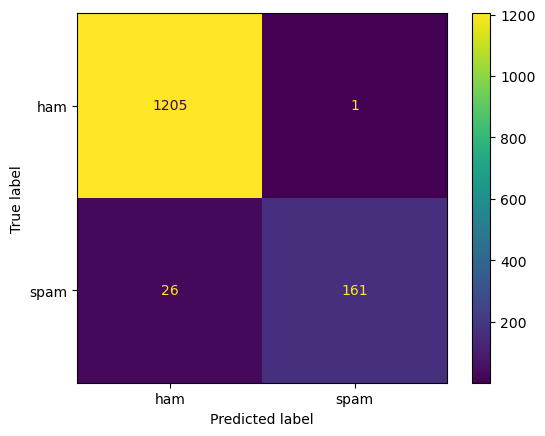

In [17]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)

In [18]:
df1 = pd.read_csv('../data/sample.csv', sep='\t', header=None)
df1.columns = ['text']
df1.head()

,text
0,Ok lar i double check wif da hair dresser alre...
1,"As a valued customer, I am pleased to advise y..."
2,"Today is ""song dedicated day.."" Which song wil..."


In [19]:
df1.iloc[0, :]

text    Ok lar i double check wif da hair dresser alre...
Name: 0, dtype: object

In [20]:
x_vect1 = tfidf.transform(df1['text'])
x_vect1.shape

(3, 6244)

In [21]:
y_pred1 = classifier.predict(x_vect1)
y_pred1

array(['ham', 'spam', 'ham'], dtype=object)

## Save the Model

In [22]:
import joblib

joblib.dump(classifier, 'model.bin')

['model.bin']

In [23]:
joblib.dump(tfidf, 'vectorizer.bin')

['vectorizer.bin']